In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import copy

# --- CONFIGURATION ---
config = {
    'data_path': r'A:\Speech Journal\melspectrograms_dataset',
    'model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'batch_size': 16,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 2,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'drop_path_rate': 0.2,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
}

In [2]:
# --- DATA PREPARATION, TRAINING, AND VALIDATION FUNCTIONS ---

def get_data_loaders(data_path, img_size, batch_size, num_workers, pin_memory):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'validation'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(data_path, 'test'), transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    class_names = train_dataset.classes
    print(f"Found classes: {class_names}")
    return train_loader, val_loader, test_loader, class_names

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
    acc = correct_predictions.double() / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), acc.item()

print("✅ Helper functions are defined.")

✅ Helper functions are defined.


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
train_loader, val_loader, test_loader, class_names = get_data_loaders(
    config['data_path'], config['img_size'], config['batch_size'], config['num_workers'], config['pin_memory']
)
num_classes = len(class_names)

# Load model
model = timm.create_model(
    config['model_name'], pretrained=True, num_classes=num_classes,
    drop_rate=config['drop_rate'], drop_path_rate=config['drop_path_rate']
)
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

print("\n✅ Model and data are ready for training!")

Using device: cuda
Found classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']

✅ Model and data are ready for training!


In [4]:
# --- PHASE 1: HEAD TRAINING ---
print("\n--- Starting Phase 1: Head Training ---")
for param in model.parameters(): param.requires_grad = False
for param in model.head.parameters(): param.requires_grad = True
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config['head_lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['head_epochs'], eta_min=1e-6)
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ New best model saved!")




--- Starting Phase 1: Head Training ---

Epoch 1/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Train Loss: 1.7793 | Val Loss: 1.5886 | Val Acc: 0.3014
✅ New best model saved!

Epoch 2/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train Loss: 1.7793 | Val Loss: 1.5003 | Val Acc: 0.4384
✅ New best model saved!

Epoch 3/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train Loss: 1.7682 | Val Loss: 1.4627 | Val Acc: 0.5205
✅ New best model saved!

Epoch 4/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Train Loss: 1.7657 | Val Loss: 1.4828 | Val Acc: 0.4932

Epoch 5/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Train Loss: 1.7563 | Val Loss: 1.4886 | Val Acc: 0.5342
✅ New best model saved!

Epoch 6/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train Loss: 1.7542 | Val Loss: 1.4703 | Val Acc: 0.4932

Epoch 7/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train Loss: 1.7376 | Val Loss: 1.5026 | Val Acc: 0.5068

Epoch 8/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train Loss: 1.7404 | Val Loss: 1.4923 | Val Acc: 0.5068

Epoch 9/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train Loss: 1.7292 | Val Loss: 1.4880 | Val Acc: 0.5205

Epoch 10/10


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

Train Loss: 1.7284 | Val Loss: 1.4872 | Val Acc: 0.5068


In [5]:
# --- PHASE 2: FULL NETWORK FINE-TUNING ---
print("\n--- Starting Phase 2: Full Fine-Tuning ---")
for param in model.parameters(): param.requires_grad = True
model.load_state_dict(best_model_wts)
optimizer = optim.AdamW(model.parameters(), lr=config['full_train_lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'] - config['lr_warmup_epochs'], eta_min=1e-6)
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda e: (e+1)/config['lr_warmup_epochs'] if e < config['lr_warmup_epochs'] else 1)
patience_counter = 0

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    if epoch < config['lr_warmup_epochs']: warmup_scheduler.step()
    else: scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ New best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= config['patience']:
        print("Early stopping triggered.")
        break

print("\n🎉 Training finished!")


--- Starting Phase 2: Full Fine-Tuning ---

Epoch 1/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train Loss: 1.6048 | Val Loss: 1.2237 | Val Acc: 0.5068

Epoch 2/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Train Loss: 1.4304 | Val Loss: 1.1722 | Val Acc: 0.6027
✅ New best model saved!

Epoch 3/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train Loss: 1.3263 | Val Loss: 1.1272 | Val Acc: 0.5205

Epoch 4/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Train Loss: 1.2632 | Val Loss: 1.0508 | Val Acc: 0.6986
✅ New best model saved!

Epoch 5/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Train Loss: 1.2077 | Val Loss: 1.0123 | Val Acc: 0.6438

Epoch 6/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Train Loss: 1.1519 | Val Loss: 1.0182 | Val Acc: 0.6712

Epoch 7/80


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Train Loss: 1.1067 | Val Loss: 0.9321 | Val Acc: 0.7397
✅ New best model saved!

Epoch 8/80


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train Loss: 1.0899 | Val Loss: 1.0474 | Val Acc: 0.6027

Epoch 9/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Train Loss: 1.0445 | Val Loss: 0.9540 | Val Acc: 0.6575

Epoch 10/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Train Loss: 1.0222 | Val Loss: 0.8933 | Val Acc: 0.6986

Epoch 11/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Train Loss: 1.0067 | Val Loss: 0.8744 | Val Acc: 0.7945
✅ New best model saved!

Epoch 12/80


Validating: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Train Loss: 0.9681 | Val Loss: 0.8384 | Val Acc: 0.8082
✅ New best model saved!

Epoch 13/80


Validating: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Train Loss: 0.9735 | Val Loss: 0.8153 | Val Acc: 0.8082

Epoch 14/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Train Loss: 0.9494 | Val Loss: 0.8294 | Val Acc: 0.7808

Epoch 15/80


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Train Loss: 0.9134 | Val Loss: 0.8642 | Val Acc: 0.7397

Epoch 16/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Train Loss: 0.9139 | Val Loss: 0.8417 | Val Acc: 0.7534

Epoch 17/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Train Loss: 0.8747 | Val Loss: 0.8471 | Val Acc: 0.7671

Epoch 18/80


Validating: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Train Loss: 0.8579 | Val Loss: 0.8586 | Val Acc: 0.8082

Epoch 19/80


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Loss: 0.8643 | Val Loss: 0.7944 | Val Acc: 0.8219
✅ New best model saved!

Epoch 20/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Train Loss: 0.8337 | Val Loss: 0.8065 | Val Acc: 0.7945

Epoch 21/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train Loss: 0.8236 | Val Loss: 0.7765 | Val Acc: 0.8219

Epoch 22/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Train Loss: 0.8083 | Val Loss: 0.7621 | Val Acc: 0.8493
✅ New best model saved!

Epoch 23/80


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train Loss: 0.8008 | Val Loss: 0.7626 | Val Acc: 0.8082

Epoch 24/80


Validating: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Train Loss: 0.7807 | Val Loss: 0.9386 | Val Acc: 0.7260

Epoch 25/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Train Loss: 0.7721 | Val Loss: 0.8611 | Val Acc: 0.7534

Epoch 26/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train Loss: 0.7441 | Val Loss: 0.9141 | Val Acc: 0.7808

Epoch 27/80


Validating: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Train Loss: 0.7357 | Val Loss: 0.8928 | Val Acc: 0.7945

Epoch 28/80


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train Loss: 0.7264 | Val Loss: 0.8925 | Val Acc: 0.7945

Epoch 29/80


Validating: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Train Loss: 0.7151 | Val Loss: 1.0402 | Val Acc: 0.6986

Epoch 30/80


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Train Loss: 0.7090 | Val Loss: 0.9122 | Val Acc: 0.7671

Epoch 31/80


Training:  77%|███████▋  | 193/252 [00:18<00:05, 10.49it/s]


KeyboardInterrupt: 


--- Evaluating on Test Set ---


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



Final Test Accuracy: 77.03%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia       1.00      1.00      1.00        13
            Laryngitis       0.50      0.46      0.48        13
           Laryngozele       0.67      0.89      0.76         9
           Vox senilis       0.69      0.85      0.76        13
             parkinson       1.00      0.92      0.96        13
spasmodische_dysphonie       0.78      0.54      0.64        13

              accuracy                           0.77        74
             macro avg       0.77      0.78      0.77        74
          weighted avg       0.78      0.77      0.77        74


Confusion matrix saved to confusion_matrix.png


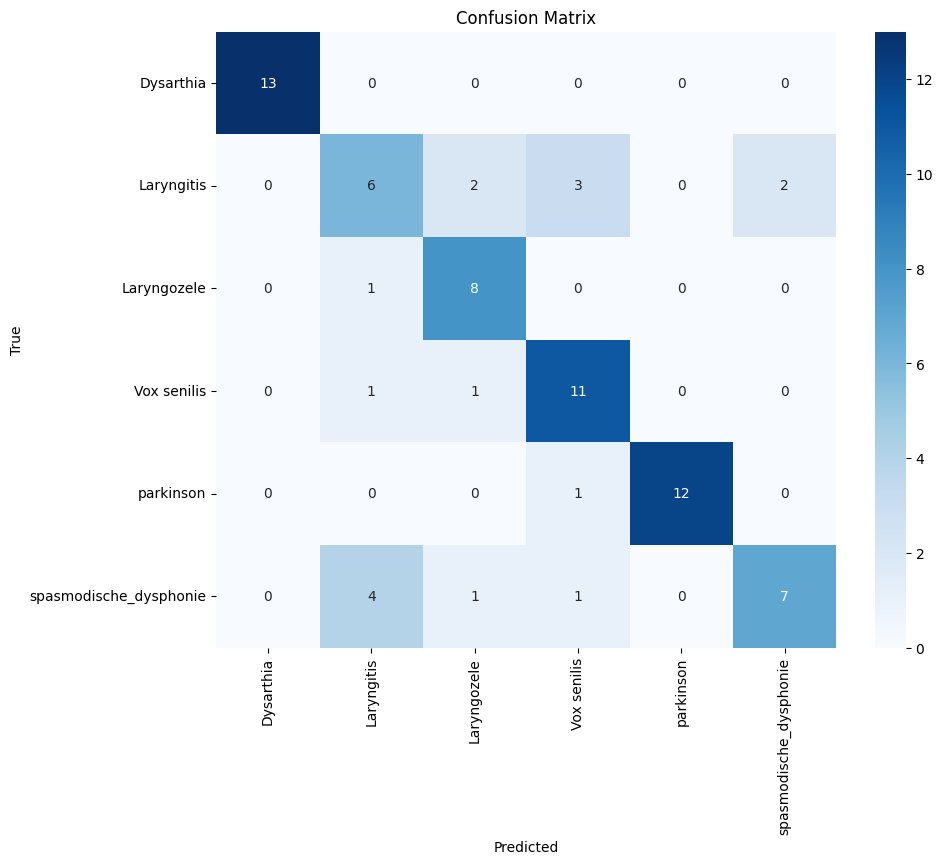

In [6]:
# --- FINAL EVALUATION ON TEST SET ---
print("\n--- Evaluating on Test Set ---")

# Create a new instance of the model architecture
evaluation_model = timm.create_model(
    config['model_name'], pretrained=False, num_classes=num_classes
)
# Load the best weights saved during training
evaluation_model.load_state_dict(torch.load('best_model.pth'))
evaluation_model.to(device)
evaluation_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        # Note: labels are not moved to device as they are used for CPU-side list extension
        outputs = evaluation_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(f"\nFinal Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png') # Save the plot
print("\nConfusion matrix saved to confusion_matrix.png")
plt.show()


🚀 STARTING ENHANCED FINAL FINE-TUNING PHASE 🚀

--- Preparing enhanced data and model for fine-tuning ---
📊 Training samples: 4021
📊 Validation samples: 73
📊 Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
   Dysarthia: 705 samples
   Laryngitis: 714 samples
   Laryngozele: 459 samples
   Vox senilis: 711 samples
   parkinson: 714 samples
   spasmodische_dysphonie: 718 samples
✅ Successfully loaded weights from 'best_model.pth'

🔧 Setting up discriminative learning rates...
   📉 Low LR (2.50e-07): cls_token
   📉 Low LR (2.50e-07): pos_embed
   📉 Low LR (2.50e-07): patch_embed.proj.weight
   📉 Low LR (2.50e-07): patch_embed.proj.bias
   📉 Low LR (2.50e-07): blocks.0.norm1.weight
   📉 Low LR (2.50e-07): blocks.0.norm1.bias
   📉 Low LR (2.50e-07): blocks.0.attn.q_bias
   📉 Low LR (2.50e-07): blocks.0.attn.v_bias
   📉 Low LR (2.50e-07): blocks.0.attn.qkv.weight
   📉 Low LR (2.50e-07): blocks.0.attn.proj.weight
   📉 Low LR (2.50e-07)

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]



📈 Epoch 1 Summary:
   Train Loss: 0.5718 | Train Acc: 0.8513
   Val Loss: 0.6490 | Val Acc: 0.8082 | F1-Score: 0.7911
   💾 New best accuracy! Accuracy: 0.8082

🎯 Enhanced Fine-Tuning Epoch 2/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]



📈 Epoch 2 Summary:
   Train Loss: 0.5307 | Train Acc: 0.8719
   Val Loss: 0.6620 | Val Acc: 0.8219 | F1-Score: 0.8027
   💾 New best accuracy! Accuracy: 0.8219

🎯 Enhanced Fine-Tuning Epoch 3/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]



📈 Epoch 3 Summary:
   Train Loss: 0.5249 | Train Acc: 0.8757
   Val Loss: 0.6762 | Val Acc: 0.8356 | F1-Score: 0.8141
   💾 New best accuracy! Accuracy: 0.8356

🎯 Enhanced Fine-Tuning Epoch 4/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]



📈 Epoch 4 Summary:
   Train Loss: 0.4986 | Train Acc: 0.8898
   Val Loss: 0.6923 | Val Acc: 0.8356 | F1-Score: 0.8160
   ⏳ No improvement (1/7)

🎯 Enhanced Fine-Tuning Epoch 5/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]



📈 Epoch 5 Summary:
   Train Loss: 0.5060 | Train Acc: 0.8841
   Val Loss: 0.7262 | Val Acc: 0.8356 | F1-Score: 0.8141
   ⏳ No improvement (2/7)

🎯 Enhanced Fine-Tuning Epoch 6/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]



📈 Epoch 6 Summary:
   Train Loss: 0.4773 | Train Acc: 0.8951
   Val Loss: 0.7267 | Val Acc: 0.8356 | F1-Score: 0.8141
   ⏳ No improvement (3/7)

🎯 Enhanced Fine-Tuning Epoch 7/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]



📈 Epoch 7 Summary:
   Train Loss: 0.4682 | Train Acc: 0.9033
   Val Loss: 0.7296 | Val Acc: 0.8493 | F1-Score: 0.8284
   💾 New best accuracy! Accuracy: 0.8493

🎯 Enhanced Fine-Tuning Epoch 8/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]



📈 Epoch 8 Summary:
   Train Loss: 0.4731 | Train Acc: 0.8993
   Val Loss: 0.7523 | Val Acc: 0.8356 | F1-Score: 0.8058
   ⏳ No improvement (1/7)

🎯 Enhanced Fine-Tuning Epoch 9/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]



📈 Epoch 9 Summary:
   Train Loss: 0.4743 | Train Acc: 0.9025
   Val Loss: 0.7544 | Val Acc: 0.8082 | F1-Score: 0.7777
   ⏳ No improvement (2/7)

🎯 Enhanced Fine-Tuning Epoch 10/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-0

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]



📈 Epoch 10 Summary:
   Train Loss: 0.4632 | Train Acc: 0.9065
   Val Loss: 0.7432 | Val Acc: 0.8356 | F1-Score: 0.8043
   ⏳ No improvement (3/7)

🎯 Enhanced Fine-Tuning Epoch 11/25
📊 Learning Rates: ['2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-06', '5.00e-06', '5.00e-06', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '2.50e-07', '5.00e-06', '5.00e-

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]



📈 Epoch 11 Summary:
   Train Loss: 0.4602 | Train Acc: 0.9065
   Val Loss: 0.7041 | Val Acc: 0.8082 | F1-Score: 0.7875
   ⏳ No improvement (4/7)

🎯 Enhanced Fine-Tuning Epoch 12/25
📊 Learning Rates: ['1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]



📈 Epoch 12 Summary:
   Train Loss: 0.4609 | Train Acc: 0.9092
   Val Loss: 0.7178 | Val Acc: 0.8356 | F1-Score: 0.8141
   ⏳ No improvement (5/7)

🎯 Enhanced Fine-Tuning Epoch 13/25
📊 Learning Rates: ['1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]



📈 Epoch 13 Summary:
   Train Loss: 0.4476 | Train Acc: 0.9164
   Val Loss: 0.7470 | Val Acc: 0.8219 | F1-Score: 0.7944
   ⏳ No improvement (6/7)

🎯 Enhanced Fine-Tuning Epoch 14/25
📊 Learning Rates: ['1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-06', '2.50e-06', '2.50e-06', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '1.25e-07', '2.50e-06', '2.50e-

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]



📈 Epoch 14 Summary:
   Train Loss: 0.4442 | Train Acc: 0.9137
   Val Loss: 0.7334 | Val Acc: 0.8356 | F1-Score: 0.8174
   ⏳ No improvement (7/7)
🛑 Early stopping triggered after 14 epochs

✅ ENHANCED FINE-TUNING COMPLETE!
🏆 Best accuracy achieved: 0.8493
📊 Best loss achieved: 0.7296
✅ Loaded best fine-tuned model for final evaluation

🎯 FINAL VALIDATION ACCURACY: 0.8493

📋 Classification Report:
                        precision    recall  f1-score   support

             Dysarthia       1.00      1.00      1.00        13
            Laryngitis       0.77      0.77      0.77        13
           Laryngozele       0.67      0.50      0.57         8
           Vox senilis       0.71      0.77      0.74        13
             parkinson       1.00      1.00      1.00        13
spasmodische_dysphonie       0.86      0.92      0.89        13

              accuracy                           0.85        73
             macro avg       0.83      0.83      0.83        73
          weighted avg

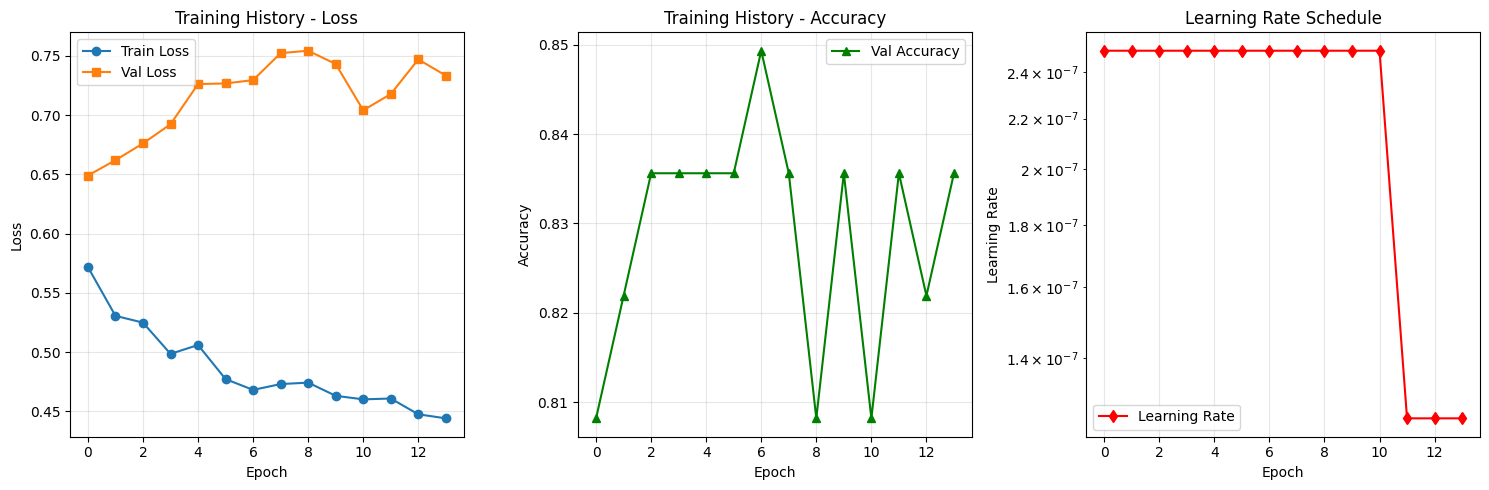


💾 Best fine-tuned model saved to 'best_finetuned_model.pth'
📈 Training history plot saved as 'fine_tuning_history.png'
🎯 Training completed with best validation accuracy: 0.8493


In [12]:
# %%
# =============================================================================
# ENHANCED FINAL LOW-LEARNING-RATE FINE-TUNING (FIXED VERSION)
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F

print("\n🚀 STARTING ENHANCED FINAL FINE-TUNING PHASE 🚀")

# --- 1. Enhanced Configuration for Fine-Tuning ---
FT_EPOCHS = 25  # Increased epochs for better convergence
FT_LEARNING_RATE = 5e-7  # Slightly higher but still conservative
BEST_MODEL_PATH = 'best_model.pth'
FINETUNED_MODEL_PATH = 'best_finetuned_model.pth'

# --- 2. Enhanced Data Preparation ---
print("\n--- Preparing enhanced data and model for fine-tuning ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enhanced transforms with mild augmentation to prevent overfitting
ft_transform_train = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    transforms.RandomHorizontalFlip(p=0.3),  # Mild augmentation
    transforms.RandomRotation(5),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1),  # Regularization
])

ft_transform_val = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset_ft = datasets.ImageFolder(root=os.path.join(config['data_path'], 'train'), transform=ft_transform_train)
val_dataset_ft = datasets.ImageFolder(root=os.path.join(config['data_path'], 'validation'), transform=ft_transform_val)

print(f"📊 Training samples: {len(train_dataset_ft)}")
print(f"📊 Validation samples: {len(val_dataset_ft)}")
print(f"📊 Classes: {train_dataset_ft.classes}")

# Calculate class distribution for debugging
class_counts = {}
for class_name, class_idx in train_dataset_ft.class_to_idx.items():
    count = sum([1 for _, label in train_dataset_ft.samples if label == class_idx])
    class_counts[class_name] = count
    print(f"   {class_name}: {count} samples")

# FIXED: Use simple shuffling instead of WeightedRandomSampler to avoid the error
train_loader_ft = DataLoader(
    train_dataset_ft, 
    batch_size=config['batch_size'], 
    shuffle=True,  # Simple shuffling instead of weighted sampler
    num_workers=config['num_workers'], 
    pin_memory=config['pin_memory']
)
val_loader_ft = DataLoader(
    val_dataset_ft, 
    batch_size=config['batch_size'], 
    shuffle=False, 
    num_workers=config['num_workers'], 
    pin_memory=config['pin_memory']
)

# --- 3. Enhanced Model Loading and Setup ---
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
print(f"✅ Successfully loaded weights from '{BEST_MODEL_PATH}'")

# Different learning rates for different layers (discriminative learning rates)
print("\n🔧 Setting up discriminative learning rates...")
params_group = []

# Check model architecture to identify layer names
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
        
    # Adjust these conditions based on your specific model architecture
    if 'classifier' in name or 'fc' in name:  # Classifier layers
        params_group.append({'params': param, 'lr': FT_LEARNING_RATE * 10})
        print(f"   📈 High LR ({FT_LEARNING_RATE * 10:.2e}): {name}")
    elif 'features.16' in name or 'layer4' in name or 'features.15' in name:  # Last feature layers
        params_group.append({'params': param, 'lr': FT_LEARNING_RATE * 2})
        print(f"   📊 Medium LR ({FT_LEARNING_RATE * 2:.2e}): {name}")
    else:  # Earlier layers - very low LR
        params_group.append({'params': param, 'lr': FT_LEARNING_RATE * 0.5})
        print(f"   📉 Low LR ({FT_LEARNING_RATE * 0.5:.2e}): {name}")

optimizer_ft = optim.AdamW(params_group, weight_decay=config['weight_decay'])

# Enhanced scheduler with plateau detection
scheduler_ft = ReduceLROnPlateau(optimizer_ft, mode='max', patience=3, factor=0.5, verbose=True)

# Enhanced loss function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

criterion_ft = LabelSmoothingCrossEntropy(smoothing=0.05)
# Alternative: use standard CrossEntropyLoss if you prefer
# criterion_ft = nn.CrossEntropyLoss()

# --- 4. Enhanced Training Loop with Additional Metrics ---
best_ft_acc = 0.0
best_ft_loss = float('inf')
patience_counter = 0
early_stopping_patience = 7

# Track metrics for analysis
train_losses = []
val_losses = []
val_accuracies = []
learning_rates = []

def calculate_f1_score(model, dataloader, device):
    """Calculate F1 score for better evaluation"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    return report['macro avg']['f1-score']

print("\n🎯 Starting enhanced fine-tuning...")
for epoch in range(FT_EPOCHS):
    print(f"\n{'='*60}")
    print(f"🎯 Enhanced Fine-Tuning Epoch {epoch+1}/{FT_EPOCHS}")
    print(f"{'='*60}")
    
    # Print learning rates for different parameter groups
    current_lrs = []
    for i, param_group in enumerate(optimizer_ft.param_groups):
        current_lrs.append(param_group['lr'])
    print(f"📊 Learning Rates: {[f'{lr:.2e}' for lr in current_lrs]}")
    learning_rates.append(current_lrs[0])  # Track first group's LR

    # Training phase with gradient clipping
    model.train()
    epoch_train_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (images, targets) in enumerate(train_loader_ft):
        images, targets = images.to(device), targets.to(device)
        
        optimizer_ft.zero_grad()
        outputs = model(images)
        loss = criterion_ft(outputs, targets)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_ft.step()
        
        epoch_train_loss += loss.item()
        
        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == targets).sum().item()
        total_samples += targets.size(0)
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f"   Batch {batch_idx}/{len(train_loader_ft)} - Loss: {loss.item():.4f}")
    
    train_loss = epoch_train_loss / len(train_loader_ft)
    train_acc = correct_predictions / total_samples
    
    # Validation phase
    val_loss, val_acc = validate_one_epoch(model, val_loader_ft, criterion_ft, device)
    
    # Calculate F1 score
    f1_score = calculate_f1_score(model, val_loader_ft, device)
    
    # Update scheduler based on validation accuracy
    scheduler_ft.step(val_acc)
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"\n📈 Epoch {epoch+1} Summary:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | F1-Score: {f1_score:.4f}")

    # Enhanced model saving with multiple criteria
    save_model = False
    improvement_message = ""
    
    if val_acc > best_ft_acc + 0.0005:  # Significant improvement in accuracy
        best_ft_acc = val_acc
        best_ft_loss = val_loss
        save_model = True
        patience_counter = 0
        improvement_message = f"💾 New best accuracy! Accuracy: {val_acc:.4f}"
    elif val_acc >= best_ft_acc and val_loss < best_ft_loss - 0.01:  # Same accuracy but lower loss
        best_ft_loss = val_loss
        save_model = True
        improvement_message = f"💾 Lower loss model! Acc: {val_acc:.4f}, Loss: {val_loss:.4f}"
    else:
        patience_counter += 1
        improvement_message = f"⏳ No improvement ({patience_counter}/{early_stopping_patience})"
    
    if save_model:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'f1_score': f1_score,
            'train_loss': train_loss,
            'train_acc': train_acc
        }, FINETUNED_MODEL_PATH)
        print(f"   {improvement_message}")
    else:
        print(f"   {improvement_message}")
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"🛑 Early stopping triggered after {epoch+1} epochs")
        break

# --- 5. Final Evaluation and Analysis ---
print(f"\n{'='*60}")
print("✅ ENHANCED FINE-TUNING COMPLETE!")
print(f"{'='*60}")
print(f"🏆 Best accuracy achieved: {best_ft_acc:.4f}")
print(f"📊 Best loss achieved: {best_ft_loss:.4f}")

# Load best model for final evaluation
if os.path.exists(FINETUNED_MODEL_PATH):
    checkpoint = torch.load(FINETUNED_MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✅ Loaded best fine-tuned model for final evaluation")

# Final comprehensive evaluation
model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for images, targets in val_loader_ft:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate final metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

final_accuracy = accuracy_score(all_targets, all_preds)
print(f"\n🎯 FINAL VALIDATION ACCURACY: {final_accuracy:.4f}")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=val_dataset_ft.classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
print("\n📊 Confusion Matrix:")
print(cm)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.title('Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green', marker='^')
plt.title('Training History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(learning_rates, label='Learning Rate', color='red', marker='d')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fine_tuning_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Best fine-tuned model saved to '{FINETUNED_MODEL_PATH}'")
print("📈 Training history plot saved as 'fine_tuning_history.png'")
print(f"🎯 Training completed with best validation accuracy: {best_ft_acc:.4f}")

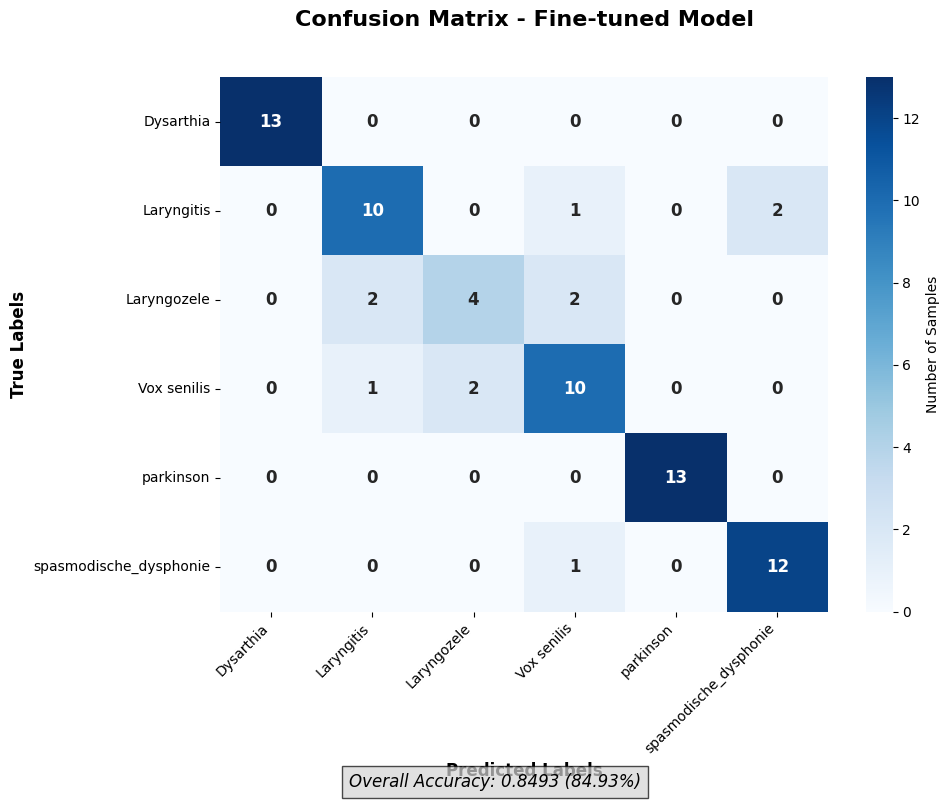

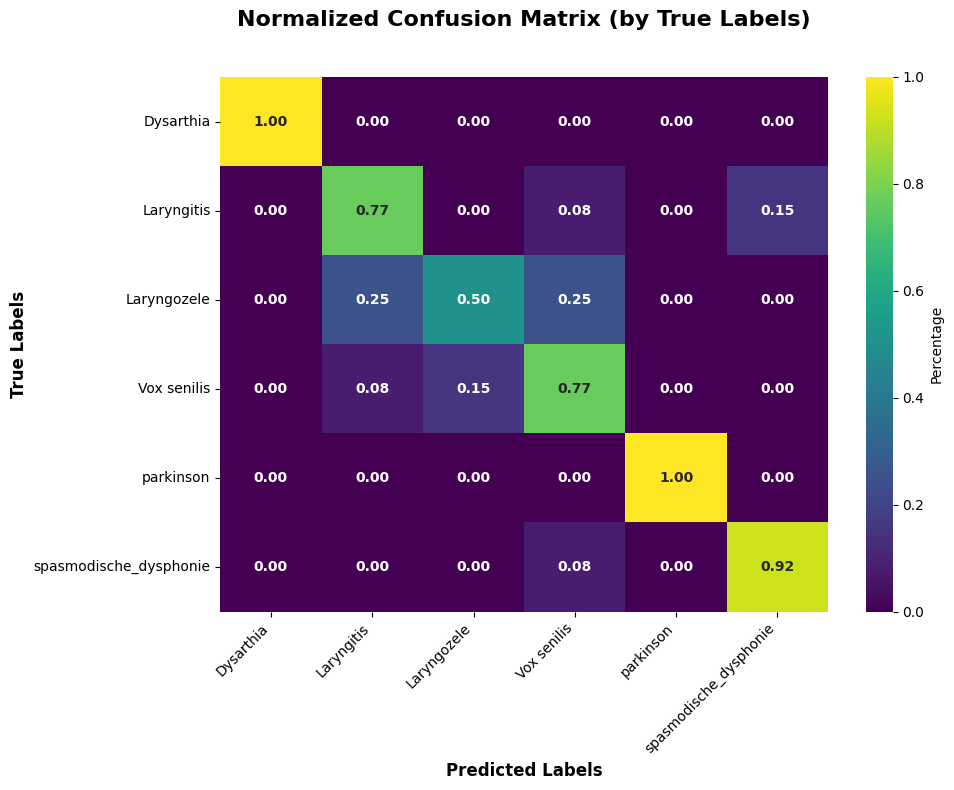


📊 DETAILED PERFORMANCE ANALYSIS:
Dysarthia      : 1.0000 (100.00%)
Laryngitis     : 0.7692 (76.92%)
Laryngozele    : 0.5000 (50.00%)
Vox senilis    : 0.7692 (76.92%)
parkinson      : 1.0000 (100.00%)
spasmodische_dysphonie: 0.9231 (92.31%)

🏆 Best performing class: Dysarthia (1.0000)
🔧 Worst performing class: Laryngozele (0.5000)

🔍 TOP MISCLASSIFICATION PATTERNS:
   Laryngitis → spasmodische_dysphonie: 2 samples (15.4%)
   Laryngozele → Laryngitis: 2 samples (25.0%)
   Laryngozele → Vox senilis: 2 samples (25.0%)
   Vox senilis → Laryngozele: 2 samples (15.4%)
   Laryngitis → Vox senilis: 1 samples (7.7%)


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create a beautiful confusion matrix heatmap
plt.figure(figsize=(10, 8))

# Convert confusion matrix to DataFrame for better labeling
cm_df = pd.DataFrame(cm, 
                     index=val_dataset_ft.classes, 
                     columns=val_dataset_ft.classes)

# Create the heatmap
ax = sns.heatmap(cm_df, 
                 annot=True, 
                 fmt='d', 
                 cmap='Blues',
                 cbar_kws={'label': 'Number of Samples'},
                 annot_kws={'size': 12, 'weight': 'bold'})

# Customize the plot
plt.title('Confusion Matrix - Fine-tuned Model\n', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add accuracy text
plt.figtext(0.5, 0.01, f'Overall Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)', 
            ha='center', fontsize=12, style='italic', 
            bbox={'facecolor': 'lightgray', 'alpha': 0.7, 'pad': 5})

plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional: Normalized confusion matrix
plt.figure(figsize=(10, 8))

# Normalize confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized_df = pd.DataFrame(cm_normalized, 
                               index=val_dataset_ft.classes, 
                               columns=val_dataset_ft.classes)

# Create normalized heatmap
ax2 = sns.heatmap(cm_normalized_df, 
                  annot=True, 
                  fmt='.2f', 
                  cmap='viridis',
                  cbar_kws={'label': 'Percentage'},
                  annot_kws={'size': 10, 'weight': 'bold'})

plt.title('Normalized Confusion Matrix (by True Labels)\n', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed performance metrics
print("\n📊 DETAILED PERFORMANCE ANALYSIS:")
print("="*50)

# Calculate per-class metrics
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(val_dataset_ft.classes):
    print(f"{class_name:<15}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# Identify best and worst performing classes
best_class_idx = np.argmax(class_accuracy)
worst_class_idx = np.argmin(class_accuracy)

print(f"\n🏆 Best performing class: {val_dataset_ft.classes[best_class_idx]} ({class_accuracy[best_class_idx]:.4f})")
print(f"🔧 Worst performing class: {val_dataset_ft.classes[worst_class_idx]} ({class_accuracy[worst_class_idx]:.4f})")

# Calculate misclassification patterns
print(f"\n🔍 TOP MISCLASSIFICATION PATTERNS:")
misclassifications = []
for i in range(len(val_dataset_ft.classes)):
    for j in range(len(val_dataset_ft.classes)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((val_dataset_ft.classes[i], val_dataset_ft.classes[j], cm[i, j]))

# Sort by frequency and show top 5
misclassifications.sort(key=lambda x: x[2], reverse=True)
for true_label, pred_label, count in misclassifications[:5]:
    percentage = count / cm.sum(axis=1)[val_dataset_ft.classes.index(true_label)] * 100
    print(f"   {true_label} → {pred_label}: {count} samples ({percentage:.1f}%)")